In [1]:
# Import necessary pyspark package
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# import for ploting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.master('local[*]').config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000").appName('BDV_Project').getOrCreate()

In [3]:
# Data Partitioning
# Question 1

In [6]:
train_data = spark.read.option("header", True).option("inferSchema", True).csv('/user/hadoop/input/shipping_companies_details_1.csv')
train_data.head(5)
print(train_data.count())

8


In [19]:
unique_values = train_data.select("shipment_mode").distinct().rdd.flatMap(lambda x: x).collect()
print(unique_values)

['Ocean', 'Air']


In [28]:
# Must define number of partitions we want to have
train_data_repartitioned = train_data.repartition(2, "shipment_mode")
train_data_repartitioned.head(5)
# Check the number of partitions
print(train_data_repartitioned.rdd.getNumPartitions())

2


In [38]:
# Exlpore data for a pattern that can be used for distributed storage
# Partition data into exactly two partitions
train_data.write.mode("overwrite").partitionBy("shipment_mode").parquet("/user/hadoop/data.parquet")

In [ ]:
# Explanatory Data Analysis
# Question 2

In [43]:
train_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- shipment_id: string (nullable = true)
 |-- send_timestamp: timestamp (nullable = true)
 |-- pick_up_point: string (nullable = true)
 |-- drop_off_point: string (nullable = true)
 |-- source_country: string (nullable = true)
 |-- destination_country: string (nullable = true)
 |-- freight_cost: double (nullable = true)
 |-- gross_weight: double (nullable = true)
 |-- shipment_charges: double (nullable = true)
 |-- shipment_mode: string (nullable = true)
 |-- shipping_company: string (nullable = true)
 |-- selected: string (nullable = true)
 |-- shipping_time: double (nullable = true)



In [44]:
train_data.show()

+---+-----------+-------------------+-------------+--------------+--------------+-------------------+------------+------------+----------------+-------------+----------------+--------+------------------+
|_c0|shipment_id|     send_timestamp|pick_up_point|drop_off_point|source_country|destination_country|freight_cost|gross_weight|shipment_charges|shipment_mode|shipping_company|selected|     shipping_time|
+---+-----------+-------------------+-------------+--------------+--------------+-------------------+------------+------------+----------------+-------------+----------------+--------+------------------+
|  0|    S000720|2019-06-08 07:17:51|            A|             Y|            GB|                 IN|       88.61|       355.0|            0.75|          Air|             SC3|       Y|           5.00741|
|  1|    S000725|2019-07-12 15:23:21|            A|             Y|            GB|                 IN|       85.65|       105.0|             0.9|        Ocean|             SC1|       Y|

In [46]:
# Count number of missing values in dataframe
train_data.describe().show()


+-------+------------------+-----------+-------------+--------------+--------------+-------------------+-----------------+-----------------+-------------------+-------------+----------------+--------+------------------+
|summary|               _c0|shipment_id|pick_up_point|drop_off_point|source_country|destination_country|     freight_cost|     gross_weight|   shipment_charges|shipment_mode|shipping_company|selected|     shipping_time|
+-------+------------------+-----------+-------------+--------------+--------------+-------------------+-----------------+-----------------+-------------------+-------------+----------------+--------+------------------+
|  count|              5114|       5114|         5114|          5114|          5114|               5114|             5114|             5114|               5114|         5114|            5114|    5114|              5114|
|   mean|            2556.5|       NULL|         NULL|          NULL|          NULL|               NULL|91.2009226460462

In [64]:
# Subset data
subset_air = train_data.filter(col("shipment_mode") == "Air")
subset_ocean = train_data.filter(col("shipment_mode") == "Ocean")

# Distribution plots for freight_cost, gross_weight, shipment_charges and shipping_time
train_data_pd = train_data.toPandas()
subset_air_pd = subset_air.toPandas()
subset_ocean_pd = subset_ocean.toPandas()

[Row(_c0=1, shipment_id='S000725', send_timestamp=datetime.datetime(2019, 7, 12, 15, 23, 21), pick_up_point='A', drop_off_point='Y', source_country='GB', destination_country='IN', freight_cost=85.65, gross_weight=105.0, shipment_charges=0.9, shipment_mode='Ocean', shipping_company='SC1', selected='Y', shipping_time=21.41215),
 Row(_c0=7, shipment_id='S001736', send_timestamp=datetime.datetime(2019, 10, 4, 14, 26, 8), pick_up_point='A', drop_off_point='Y', source_country='GB', destination_country='IN', freight_cost=86.7, gross_weight=65.0, shipment_charges=0.9, shipment_mode='Ocean', shipping_company='SC1', selected='Y', shipping_time=11.01481),
 Row(_c0=11, shipment_id='S002728', send_timestamp=datetime.datetime(2019, 8, 2, 15, 2, 32), pick_up_point='A', drop_off_point='Y', source_country='GB', destination_country='IN', freight_cost=83.56, gross_weight=400.0, shipment_charges=0.9, shipment_mode='Ocean', shipping_company='SC1', selected='Y', shipping_time=21.26759),
 Row(_c0=12, shipmen

In [124]:
groupByShipment = train_data.rdd.map(lambda row: (row.shipment_mode, (row.destination_country, row.freight_cost, row.gross_weight, row.shipment_charges, row.shipping_time))).groupByKey().collect()

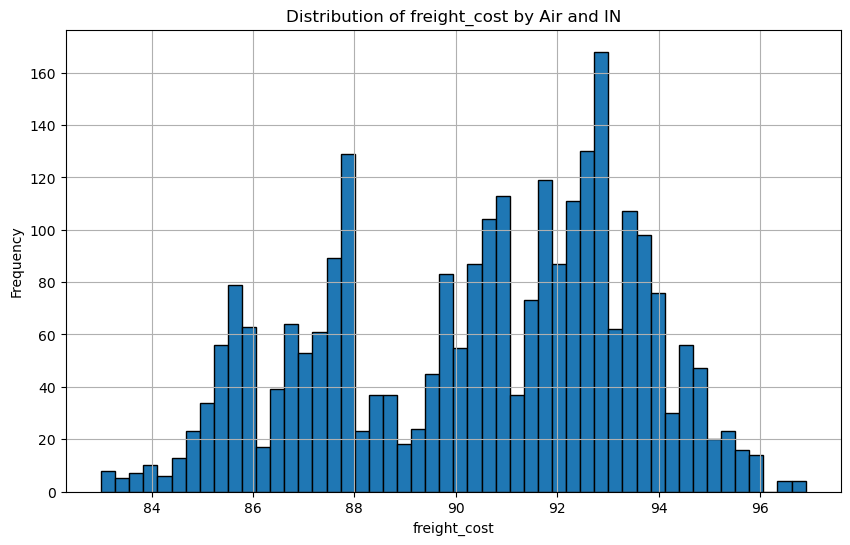

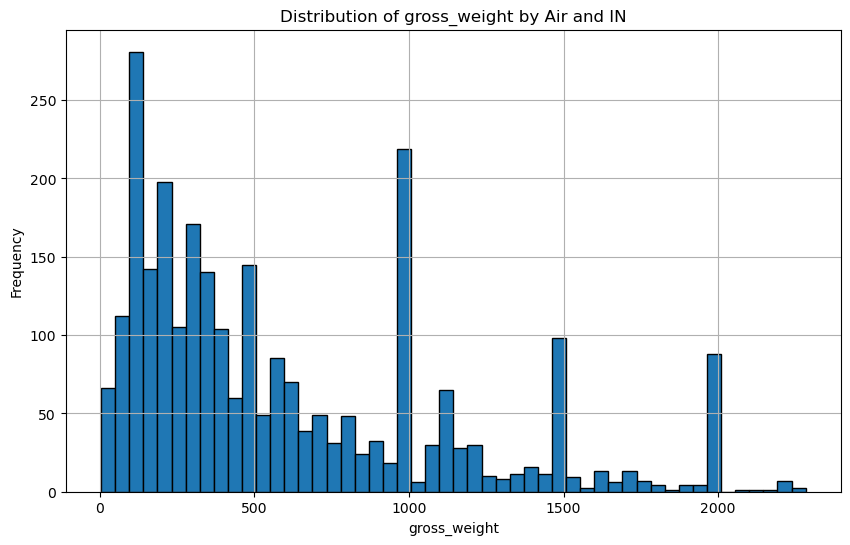

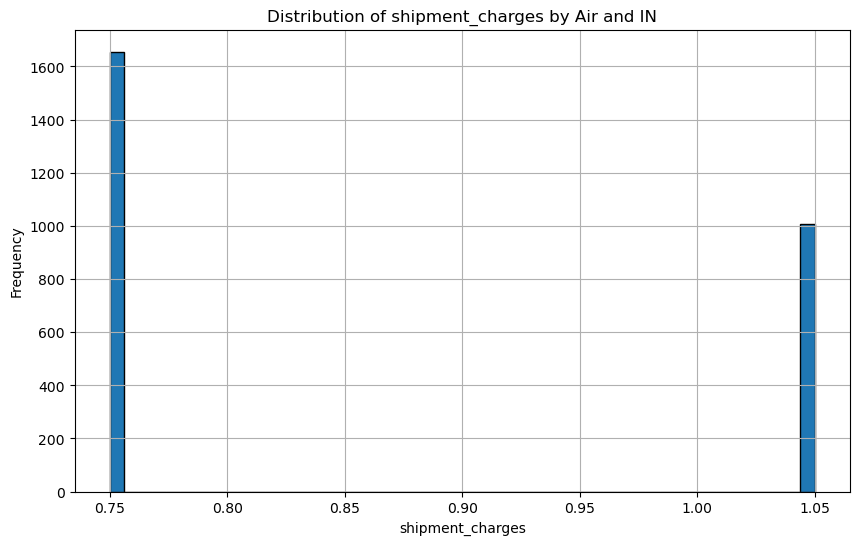

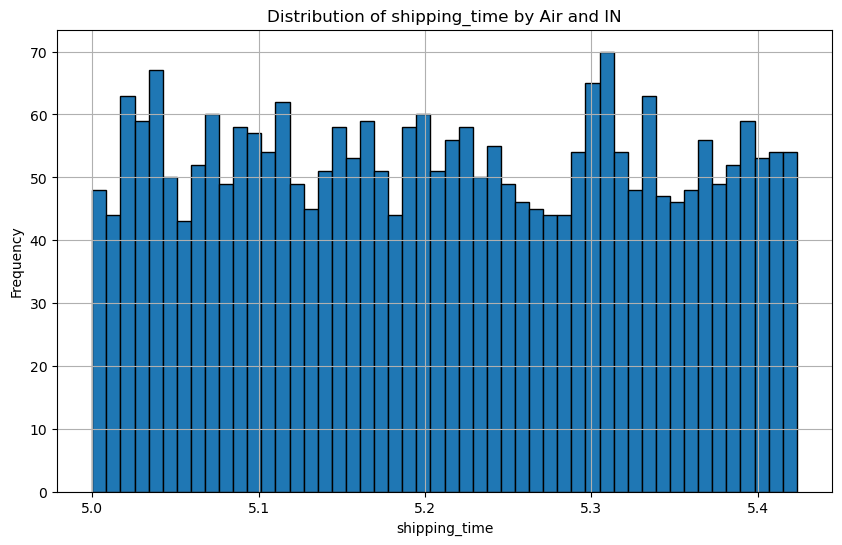

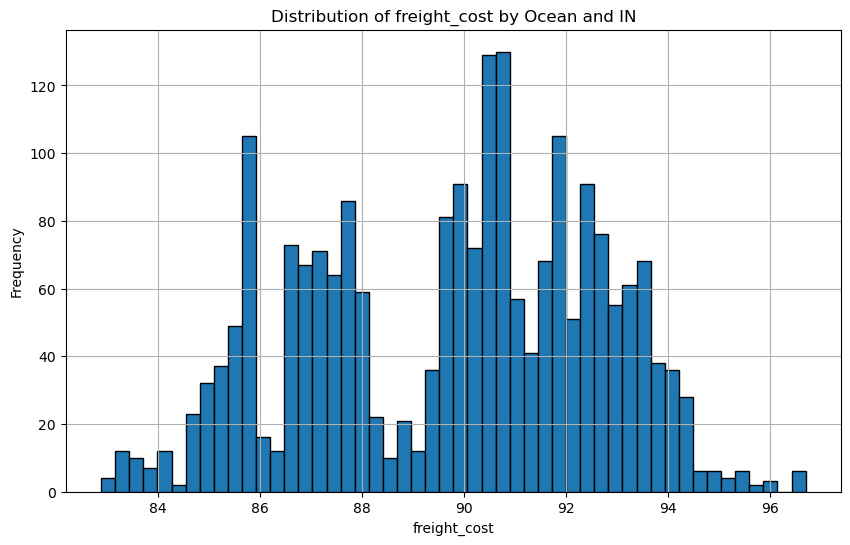

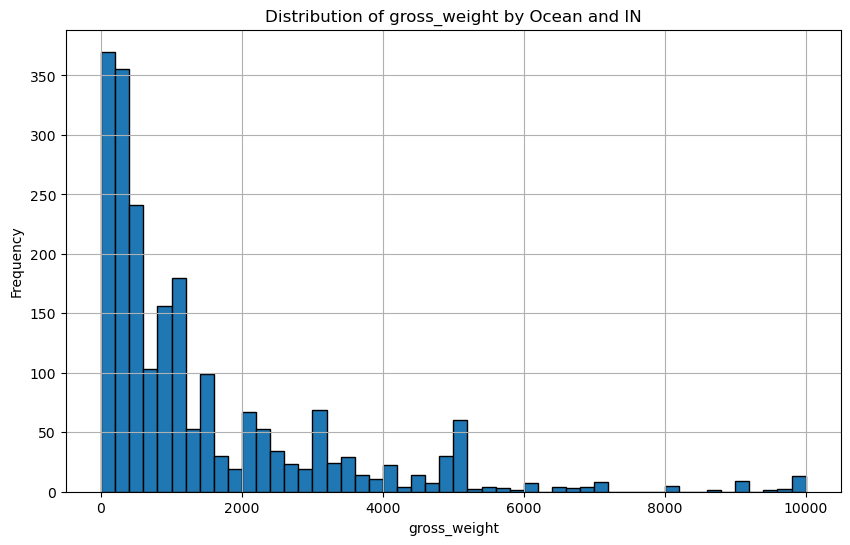

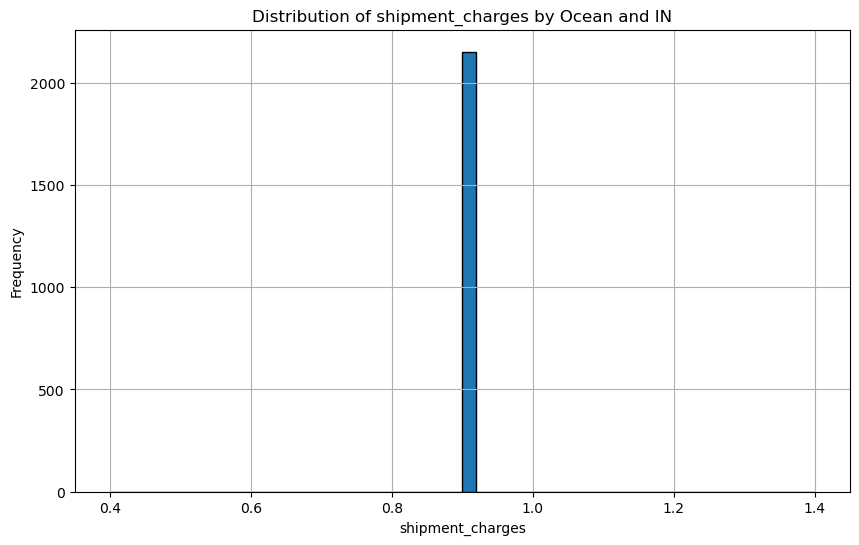

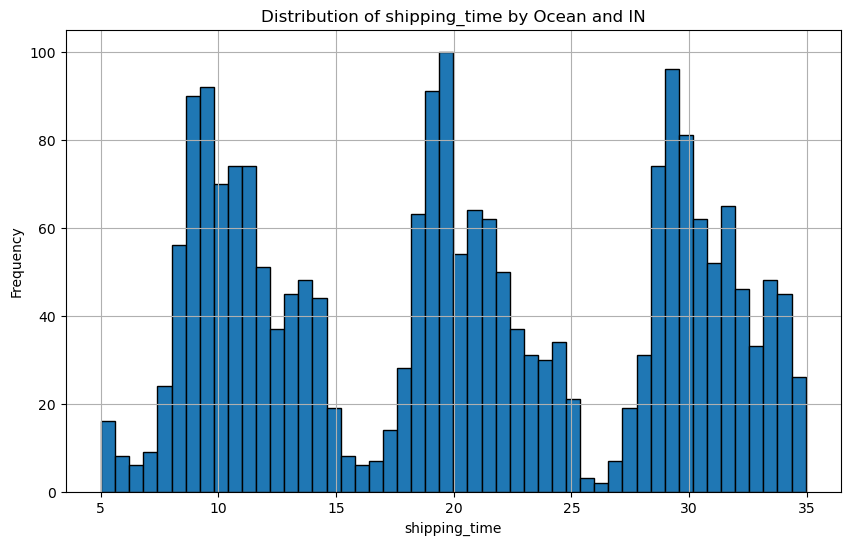

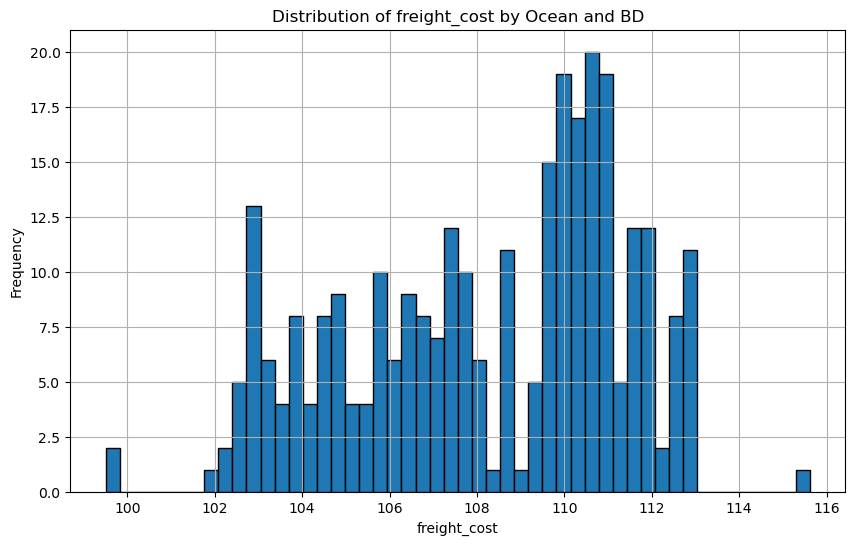

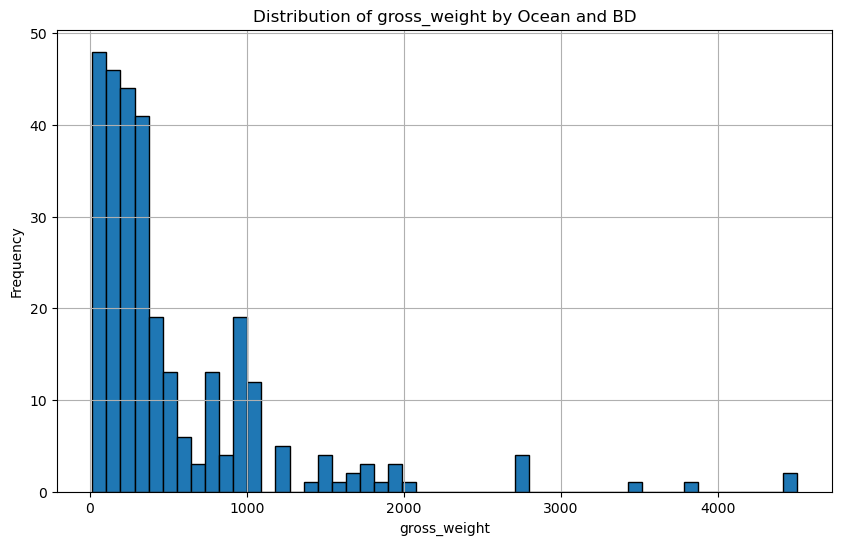

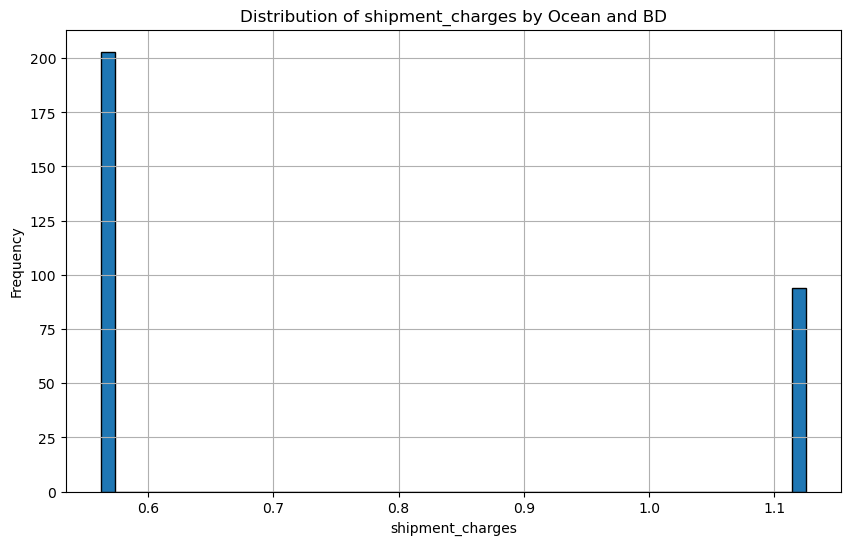

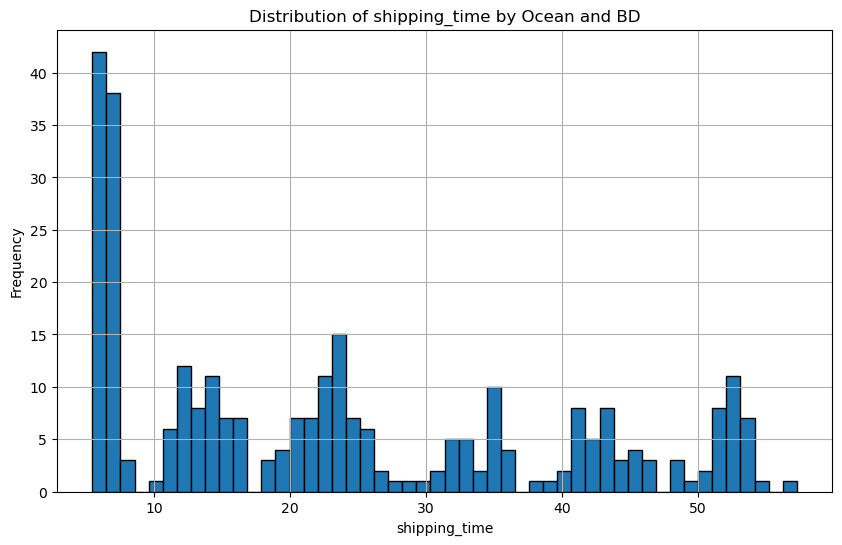

In [139]:
for key, value in groupByShipment:
    # Group country again
    value_df = spark.createDataFrame(value, schema=["destination_country","freight_cost", "gross_weight", "shipment_charges", "shipping_time"])
    groupByCountry = value_df.rdd.map(lambda row: (row.destination_country, (row.freight_cost, row.gross_weight, row.shipment_charges, row.shipping_time))).groupByKey().collect()
    for countryKey,countryValue in groupByCountry: 
        value_pd = pd.DataFrame(countryValue, columns = ["freight_cost", "gross_weight", "shipment_charges", "shipping_time"])
        for colName in value_pd.columns:
                plt.figure(figsize=(10, 6))
                plt.hist(value_pd[colName], bins=50, edgecolor='black')
                plt.title("Distribution of " + colName + " by " + key + " and " + countryKey)
                plt.xlabel(colName)
                plt.ylabel("Frequency")
                plt.grid(True)
                plt.show()


In [ ]:
# TODO: Shipping Costs do not scale with gross weight

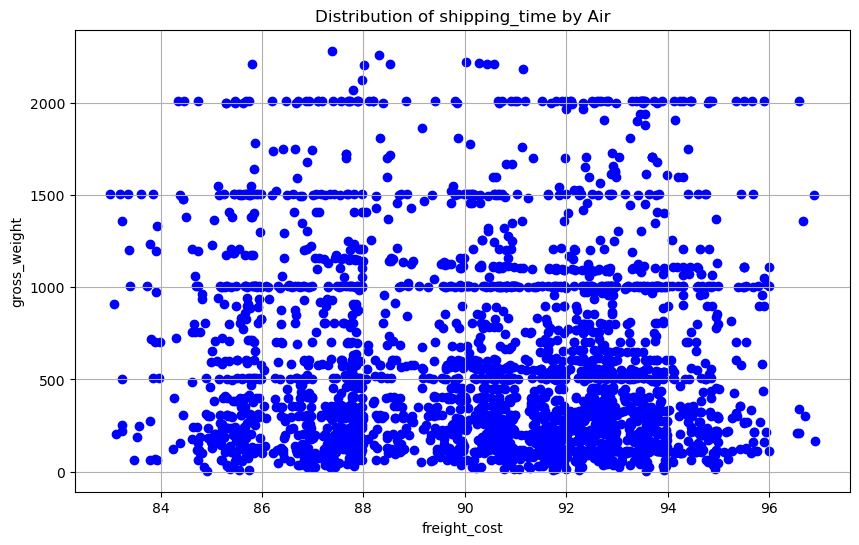

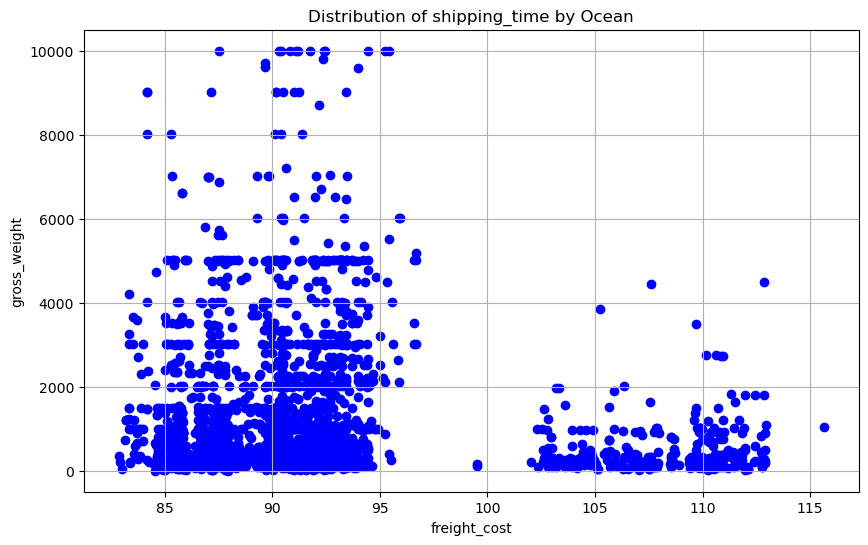

In [110]:
# Correlation Shipping Time and Shipment Mode
for key, value in groupByShipment:
    #print(f"Key: {key}, Value: {value}")
    value_pd = pd.DataFrame(value, columns = ["freight_cost", "gross_weight", "shipment_charges", "shipping_time"])
    plt.figure(figsize=(10, 6))
    plt.scatter(value_pd["freight_cost"], value_pd["gross_weight"], color='blue')
    plt.title("Distribution of " + colName + " by " + key)
    plt.xlabel("freight_cost")
    plt.ylabel("gross_weight")
    plt.grid(True)
    plt.show()

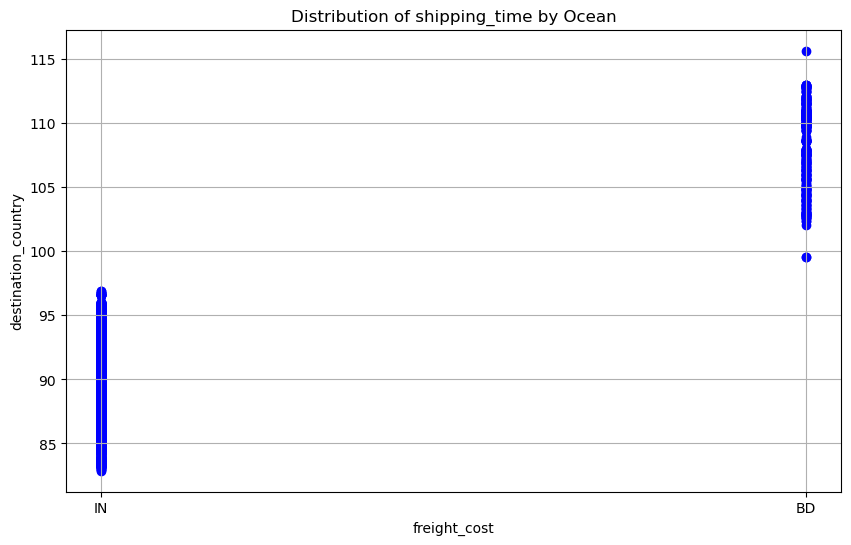

In [112]:
# Insight - costs vary extremly by country India / Bangladesh
plt.figure(figsize=(10, 6))
plt.scatter(train_data_pd["destination_country"], train_data_pd["freight_cost"], color='blue')
plt.title("Distribution of reight_cost by " + key)
plt.xlabel("freight_cost")
plt.ylabel("destination_country")
plt.grid(True)
plt.show()

In [114]:
print(train_data.rdd.filter(lambda row: row.destination_country == "BD").count())

297


In [116]:
print(train_data.rdd.filter(lambda row: row.destination_country == "IN").count())

4817


In [ ]:
# Most likely to remove values from bangladesh and perform training on a dedicated dataset


In [144]:
groupByCountry = train_data.rdd.map(lambda row: (row.destination_country, (row.shipment_mode, row.freight_cost, row.gross_weight, row.shipment_charges, row.shipping_time))).groupByKey().collect()

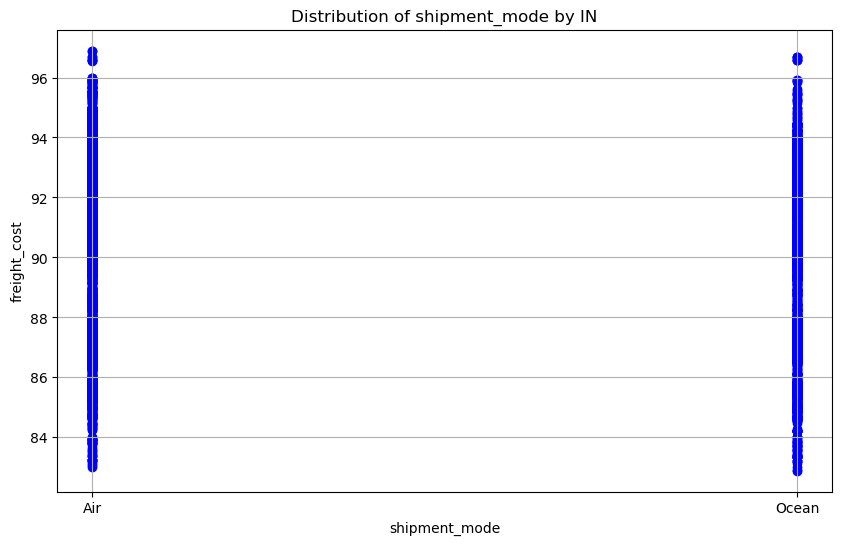

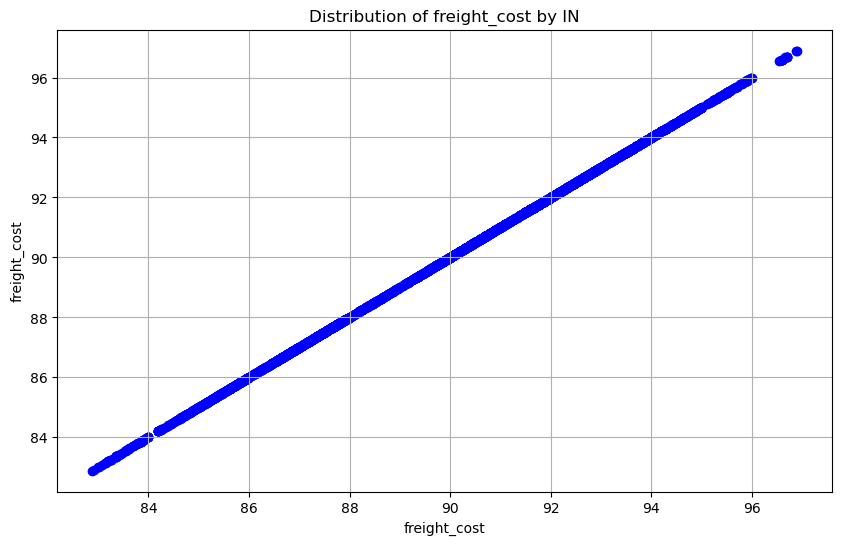

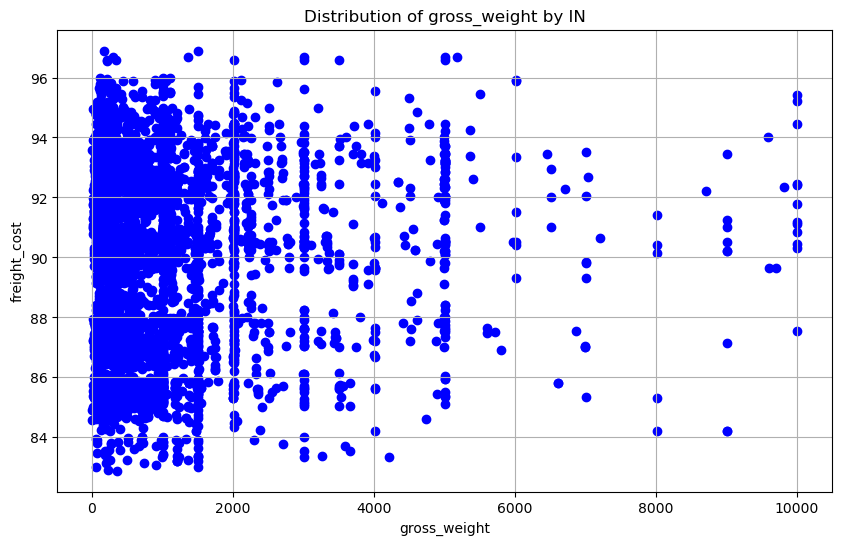

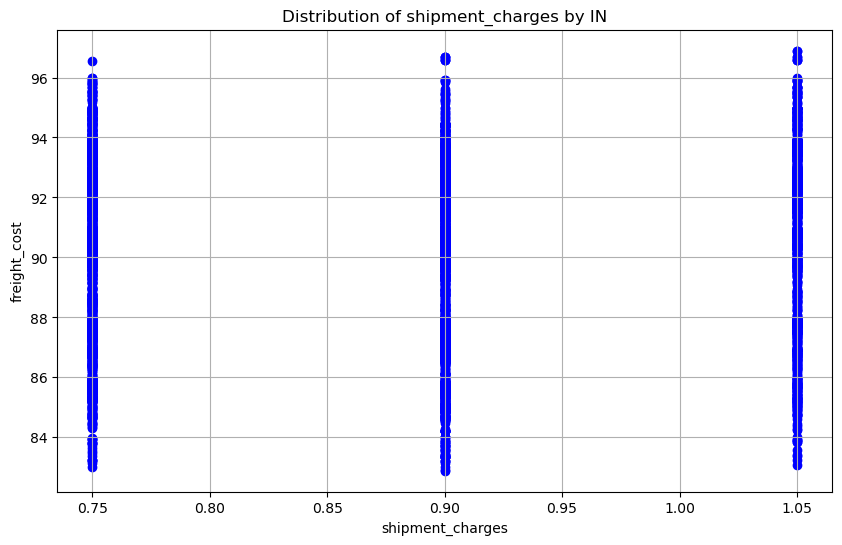

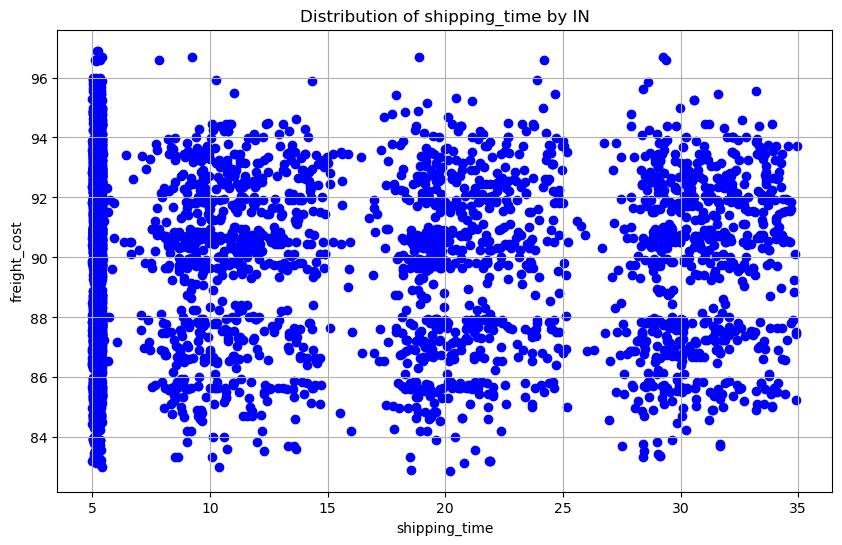

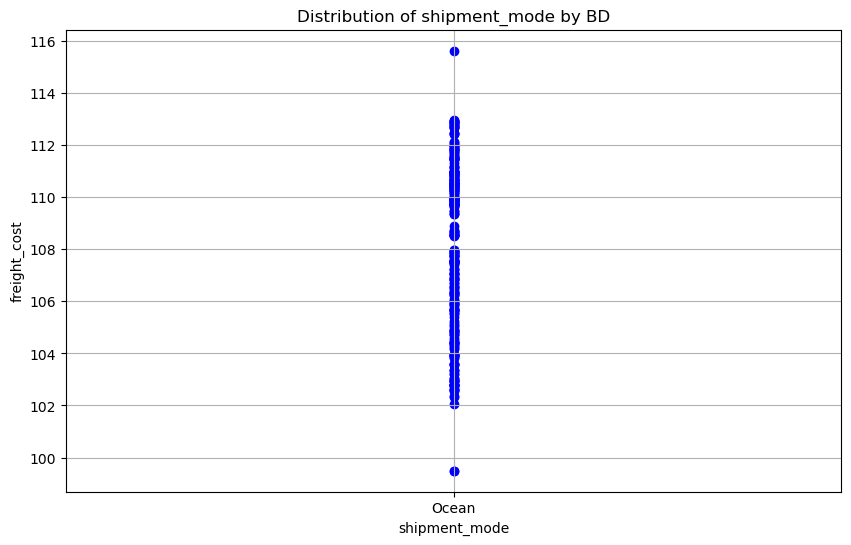

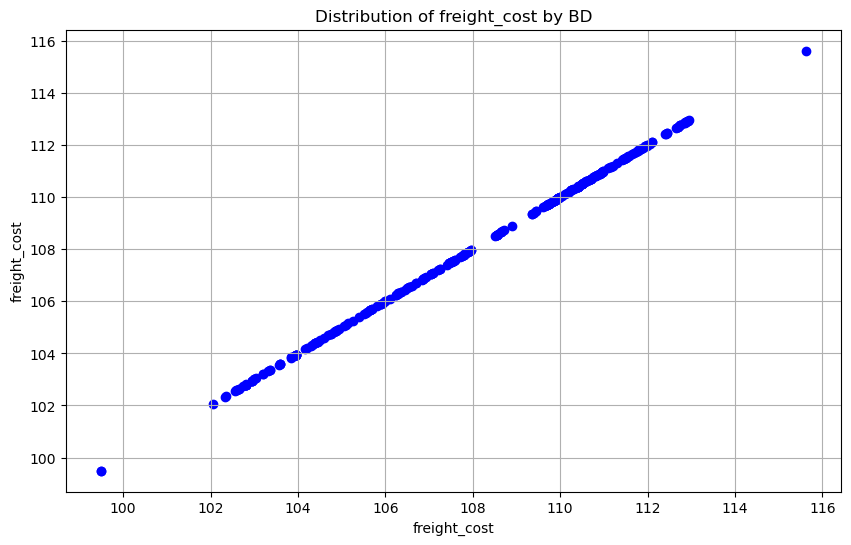

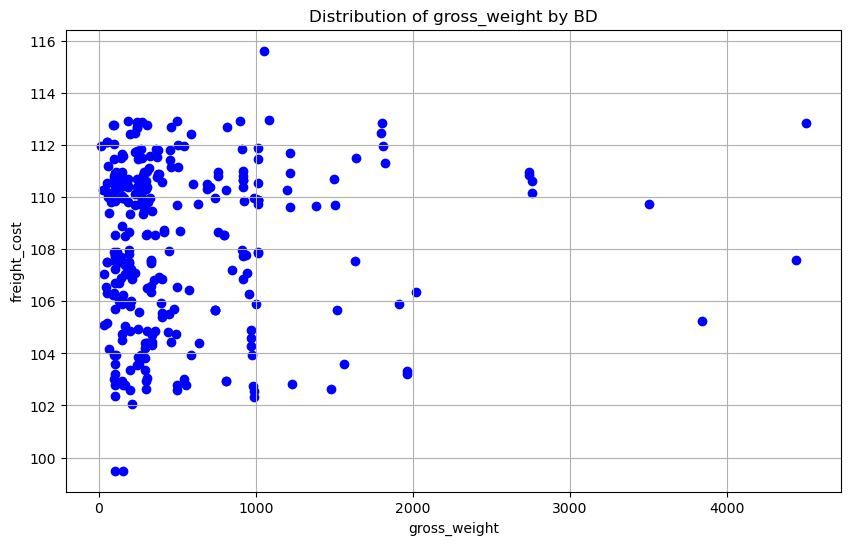

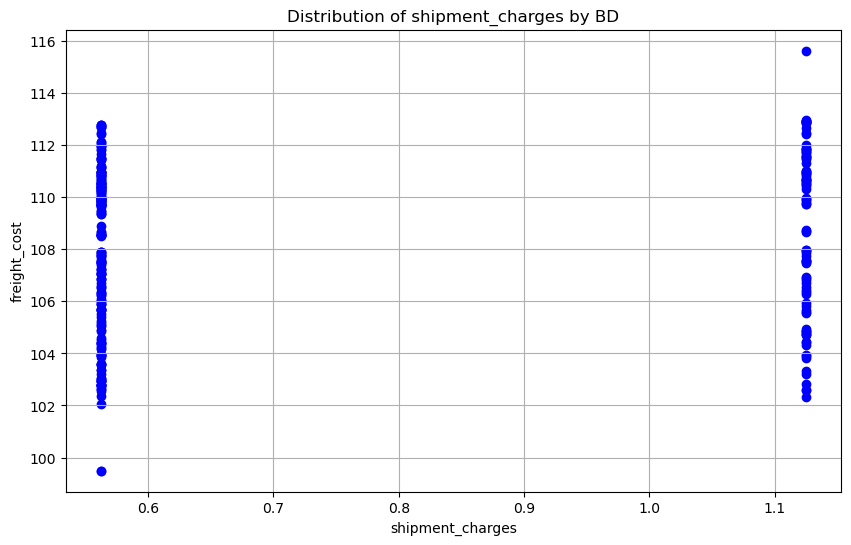

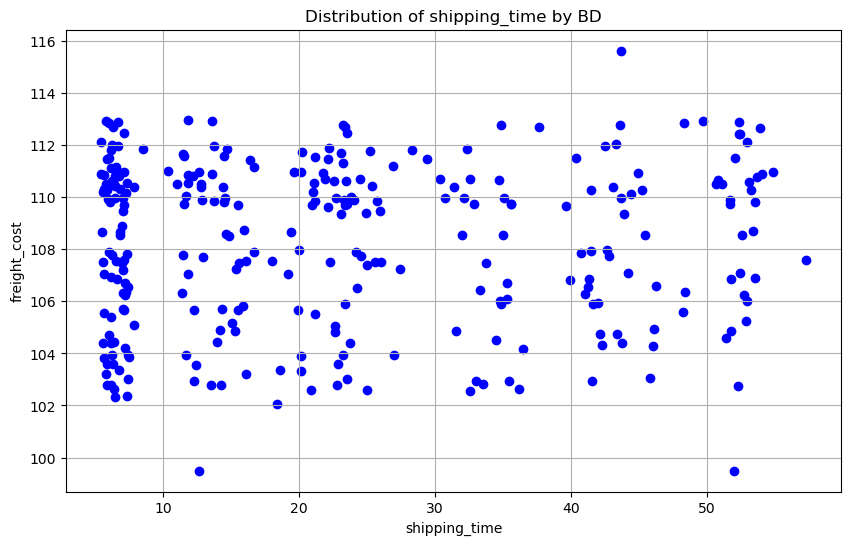

In [145]:
for key, value in groupByCountry:
    value_pd = pd.DataFrame(value, columns = ["shipment_mode", "freight_cost", "gross_weight", "shipment_charges", "shipping_time"])
    for colName in value_pd.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(value_pd[colName], value_pd["freight_cost"], color='blue')
        plt.title("Distribution of " + colName + " by " + key)
        plt.xlabel(colName)
        plt.ylabel("freight_cost")
        plt.grid(True)
        plt.show()